# Digit dataset backpropagation
By Gerrit van de Bunt, 1756708, 2020-2021\
In this short notebook we will analyse the digit dataset and, based on this analysis, configure a Neural Network using our own code to train upon and classify the entries in this dataset.

# Step 0
Import the necessary tools.\
**Note: Due to jupyter notebook importing issues, we will be using a couple of cells to define all the code in our notebook, which drastically increases it's size.** 

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas
import random
import time

In [2]:
# Activation classes. The idea is as follows;
# The classes should have attributes, but should ultimately be callable to be used in the Perceptrons, in order
# to return an output.

# To this end, make sure that implemented classes have an activate() function that only takes a int or float input
# and outputs a int or float.

from typing import Union
import math

class Step:
    """Step-based activation. If the sum of the input is above the treshold, the output is 1. Otherwise,
    the output is 0."""
    def __init__(self, treshold: Union[int, float] = 0):
        self.treshold = treshold

    def activate(self, input: Union[int, float]):
        if input >= self.treshold:
            return 1
        else:
            return 0

class Sigmoid:
    """Sigmoid-based activation. The output is defined by the sigmoid function."""
    def __init__(self):
        """Creates the object."""

    def activate(self, input: Union[int, float]):
        return 1 / (1 + (math.e ** -input))


In [3]:
# Neuron class. Takes a list of inputs, applies a list of weights to them, adds a bias,
# then applies the sum of that to the activation function and returns an output.

from typing import List, Union

class Neuron:
    """Neuron class. To initialise, takes a list of weights, an activation function (normally Sigmoid().activate()), and a bias (optional).
    Once initialised, can be activated by giving a list of inputs (with equal elements to the amount of weights)"""
    def __init__(self, weights: List[Union[int, float]], activation: callable, ID=0, bias: Union[int,float] = 0.0):
        """Initialises the neuron."""
        # FUNCTIONAL VARIABLES (Private)
        self.__weights = weights
        self.__activation = activation
        self.__bias = bias

        self.__newweights = []
        self.__newbias = 0

        # LOGGING VARIABLES (Public)
        self.ID = ID  # Identifier for Perceptron, for debugging.

        self.error = 0  # Error calculated by the error methods.

        self.hasrun = False  # Whether the neuron has been activated or not.
        self.input = []  # Inputs of previous activations
        self.output = []  # Output of previous activations

    def getweights(self) -> List[Union[int, float]]:
        """Returns the current weights."""
        return self.__weights

    def setweights(self,weights: List[Union[int, float]]):
        """Changes the weights on this neuron by using a supplied weightslist.
        For proper use in the PerceptronLayer class, the input has to have the same
        amount of elements as the original weights list."""
        if not len(weights) == len(self.getweights()):
            raise Exception("Amount of supplied weights does not equal the amount of current weights @ Perceptron {}".format(self.ID))
        self.__weights = weights

    def getactivation(self) -> callable:
        """Returns the current activation function."""
        return self.__activation

    def setactivation(self, func: callable):
        """Changes the activation function on this neuron."""
        self.__activation = func

    def getbias(self) -> Union[int, float]:
        """Returns the current bias for this neuron."""
        return self.__bias

    def setbias(self, b: Union[int, float]):
        """Changes the current bias on this neuron."""
        self.__bias = b

    def activate(self,inputs: List[Union[int, float]]) -> Union[int,float]:
        """Activates the Perceptron by supplying inputs."""
        # RESETS
        self.hasrun = False
        # PRECHECKS
        if not len(inputs) == len(self.__weights):
            raise Exception("Amount of inputs is not equal to the amount of weights @ Perceptron {}".format(self.ID))
        # PROCESSING
        weightedlist = []  # List with processed inputs (input*weight)

        for indx in range(len(self.__weights)):
            weightedlist.append(self.__weights[indx] * inputs[indx])

        output = self.__activation(sum(weightedlist) + self.__bias)
        # Consider evaluation succesful past this point; get logging variables.
        self.hasrun = True
        self.input.append(inputs)
        self.output.append(output)

        return output

    def erroroutput(self, target: Union[int,float], learningrate: Union[int,float]):
        """Calculates the error of an output neuron."""
        if not self.hasrun:
            raise Exception("Run the Neuron first! @ Neuron {}".format(self.ID))
        gradients = []
        deltaweights = []
        deltabias = 0
        newweights = []
        newbias = 0
        # Bepaal de error
        output = self.output[-1]
        error = output * (1-output) * -(target-output)
        for inp in self.input[-1]:
            gradients.append(inp * error)  # De output van een voorgaande node is gelijk aan de input op deze node op de relevante index
        for grad in gradients:
            deltaweights.append(learningrate * grad)
        deltabias = learningrate * error

        self.error = error
        self.__newweights = [self.__weights[i] - deltaweights[i] for i in range(len(self.getweights()))]
        self.__newbias = self.getbias() - deltabias

    def errorhidden(self, connections: List[Union[int,float]], errors: List[Union[int,float]], learningrate: Union[int,float]):
        """Calculates the error of a hidden layer neuron"""
        if not self.hasrun:
            raise Exception("Run the Neuron first! @ Neuron {}".format(self.ID))
        if len(connections) != len(errors):
            raise Exception("Amount of connections from this neuron should equal the amount of errors from neurons @ Neuron {}".format(self.ID))
        gradients = []
        deltaweights = []
        deltabias = 0
        newweights = []
        newbias = 0
        sum = 0  # Sum of (Wi,j * Delta(j))
        # Bepaal de error
        output = self.output[-1]
        for i in range(len(connections)):  # Bepaal eerst de som van de vermenigvuldigingen tussen de verbindingen en de errors.
            sum += connections[i] * errors[i]
        error = output * (1-output) * sum  # Bepaal dan uiteindelijk de error.
        for inp in self.input[-1]:
            gradients.append(inp * error)  # De output van een voorgaande node is gelijk aan de input op deze node op de relevante index
        for grad in gradients:
            deltaweights.append(learningrate * grad)
        deltabias = learningrate * error

        self.error = error
        self.__newweights = [self.__weights[i] - deltaweights[i] for i in range(len(self.getweights()))]
        self.__newbias = self.getbias() - deltabias

    def update(self):
        """Updates the weights and bias using stored new weights and bias."""
        self.setbias(self.__newbias)
        self.setweights(self.__newweights)

    def __str__(self) -> str:
        """Returns a string representing the object and it's variables."""
        output = ""
        output += "NEURON ID: {}\n\n".format(self.ID)

        output += "WEIGHTS: {}\n".format(self.getweights())
        output += "ACTIVATION: {}\n".format(self.getactivation().__name__)
        output += "BIAS: {}\n".format(self.getbias())

        if self.hasrun:
            output += "SUCCESFUL ACTIVATION \n\n".format(self.hasrun)
            output += "INPUT: {}\n".format(self.input)
            output += "OUTPUT: {}\n".format(self.output)
        else:
            output += "ACTIVATION PENDING/FAILED\n"

        return output

In [4]:
# NeuronLayer defines the layers in the network. This is where the Neuron Class is used.

# By default, all the Layers must be connected, so each neuron in the network must have equally as many
# weights as one another, and the amount of weights on all perceptrons should equal the amount of connections from one layer to the
# other on a per-neuron basis.

from typing import List, Union, Any

class NeuronLayer:
    """Defines a layer in a NeuronNetwork."""
    def __init__(self, neurons: List[Neuron], ID: Any = 0):
        self.neurons = neurons
        self.outputs = []

    def activate(self, inputlist: List[Union[int, float]]):
        """Runs the inputlist through all perceptrons of the network and saves the output."""
        self.outputs = []
        for i in self.neurons:
            i.activate(inputlist)
            self.outputs.append(i.output[-1])

In [5]:
# The NeuronNetwork houses **all** the layers of the network.

from typing import List, Union, Any  # Onschuldige library die alleen beter laat zien wat voor soorten inputs er verwacht worden.

class NeuronNetwork:
    """Defines the neuron network; wraps all the given layers into this network."""
    def __init__(self, layers: List[NeuronLayer], learningrate: Union[int,float] = 0.3, ID: Any = 0):
        """Initialises a neuron network. Handles the connections between the layers."""
        self.hiddenlayers = layers
        self.learningrate = learningrate
        self.input = []
        self.output = []

        self.ID = ID
        self.hasrun = False

    def feed_forward(self, inputs: List[Union[int,float]]) -> List[Union[int,float]]:
        """Starts the network, feeds in the inputs, runs it through all the layers and returns the output
        of the final layer."""
        self.hasrun = False
        totalinputs = inputs.copy()  # Keep both lists unlinked; original list will be saved for debugging.
        for layer in self.hiddenlayers:
            layer.activate(totalinputs)
            totalinputs = layer.outputs.copy()  # Same deal here

        self.input = inputs
        self.output = totalinputs
        self.hasrun = True

        return totalinputs

    def backpropagation(self, actualoutput):
        outputlayer = self.hiddenlayers[-1]

        if len(outputlayer.neurons) != len(actualoutput):
            raise Exception("Not enough outputs for each neuron in the output layer @ NeuronNetwork {}".format(self.ID))

        for i in range(len(outputlayer.neurons)):
            outputlayer.neurons[i].erroroutput(actualoutput[i],self.learningrate)
        # Nu komt het lastige gedeelte...
        # Amount of connections is equal to the amount of neurons in the previous layer!!
        # Currentlayer (i) : Target to call .errorhidden() on. Also get index in the neuron list.
        # Nextlayer (i+1) : Target to get weights from. Use index acquired in the previous layer.
        for lindx in range(len(self.hiddenlayers)-2,-1,-1):
            for i in range(len(self.hiddenlayers[lindx].neurons)):
                weights = []
                errors = []
                for neuron in self.hiddenlayers[lindx+1].neurons:
                    weights.append(neuron.getweights()[i])  # Gets the weights that this neuron connects to on neurons in the next layer
                    errors.append(neuron.error)  # Gets the error at the same time.
                self.hiddenlayers[lindx].neurons[i].errorhidden(weights,errors,self.learningrate)

    def update(self):
        """Updates all the weights and biases in the network immediately, given
        that all neurons have had their """
        for layer in self.hiddenlayers:
            for neuron in layer.neurons:
                neuron.update()

    def train(self, inputs: List[List[int]], actualoutputs: List[List[int]], epochs: int = 40, errortreshold: float = 0.1) -> None:
        error = errortreshold+1
        while epochs > 0 and error >= errortreshold:
            for i in range(len(inputs)):
                start = time.time()
                self.feed_forward(inputs[i])
                print("Feeding forward: {} seconds".format((time.time() - start)))
                self.backpropagation(actualoutputs[i])
                print("Backpropagating: {} seconds".format((time.time() - start)))
                self.update()
                print("Updating: {} seconds".format((time.time() - start)))
#                 print("Calculating error: {} seconds".format((time.time() - start)))
                print("Loop finished: {} seconds".format((time.time() - start)))
            error = self.error(inputs,actualoutputs)  # MSE
            epochs -= 1

    def error(self, inputs: List[List[Union[int,float]]], actualoutputs: List[List[Union[int,float]]]) -> float:
        """Calculates the MSE of this network's output layer over a training set."""
        outputs = []
        sumoutputs = []
        for i in range(len(inputs)):
            self.feed_forward(inputs[i])
            outputs.append(self.output)
            # Verwijder ook hier weer de resulterende inputs en outputs, die willen we niet; error moet gezien
            # worden als een functie zonder side-effects.
            for neuronlayer in self.hiddenlayers:
                for neuron in neuronlayer.neurons:
                    del neuron.output[-1]
                    del neuron.input[-1]

        for i1 in range(len(outputs)):
            for i2 in range(len(outputs[i1])):
                sumoutputs.append((actualoutputs[i1][i2] - outputs[i1][i2])**2)

        return sum(sumoutputs) / len(outputs)

    def __str__(self):
        """Tries to print out the network in a readable manner.
        Additional information is available once the network has been run once."""
        output = ""
        output += "NEURONNETWORK ID: {}\n".format(self.ID)
        if self.hasrun:
            output += "INPUT: {}\nV\n".format(self.input)
        for layer in self.hiddenlayers:
            for i in layer.neurons:
                output += "[{} + {}]\n".format([round(x,4) for x in i.getweights()],round(i.getbias(),4))
            if self.hasrun:
                output += "OUTPUT: {}\n".format(layer.outputs)
            output += "V\n"
        if self.hasrun:
            output += "FINAL OUTPUT: {}\n".format(self.output)
        else:
            output += "ACTIVATION PENDING\n"
        return output


# Stap 1 - Data collection
Importeer de dataset en kijk naar de eerste gegevens

In [6]:
data = load_digits(as_frame=True)
frame = data["frame"]
frame

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        5.0       13.0        9.0        1.0   
1           0.0        0.0        0.0       12.0       13.0        5.0   
2           0.0        0.0        0.0        4.0       15.0       12.0   
3           0.0        0.0        7.0       15.0       13.0        1.0   
4           0.0        0.0        0.0        1.0       11.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        0.0        4.0       10.0       13.0        6.0   
1793        0.0        0.0        6.0       16.0       13.0       11.0   
1794        0.0        0.0        1.0       11.0       15.0        1.0   
1795        0.0        0.0        2.0       10.0        7.0        0.0   
1796        0.0        0.0       10.0       14.0        8.0        1.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0           0.0        0.0        0.0        0.0  ...        0.0        0.0   
1           0.0        0.0        0.0        0.0  ...        0.0        0.0   
2           0.0        0.0        0.0        0.0  ...        0.0        0.0   
3           0.0        0.0        0.0        8.0  ...        0.0        0.0   
4           0.0        0.0        0.0        0.0  ...        0.0        0.0   
...         ...        ...        ...        ...  ...        ...        ...   
1792        0.0        0.0        0.0        1.0  ...        0.0        0.0   
1793        1.0        0.0        0.0        0.0  ...        0.0        0.0   
1794        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1795        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1796        0.0        0.0        0.0        2.0  ...        0.0        0.0   

      pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0           0.0        6.0       13.0       10.0        0.0        0.0   
1           0.0        0.0       11.0       16.0       10.0        0.0   
2           0.0        0.0        3.0       11.0       16.0        9.0   
3           0.0        7.0       13.0       13.0        9.0        0.0   
4           0.0        0.0        2.0       16.0        4.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        2.0       14.0       15.0        9.0        0.0   
1793        0.0        6.0       16.0       14.0        6.0        0.0   
1794        0.0        2.0        9.0       13.0        6.0        0.0   
1795        0.0        5.0       12.0       16.0       12.0        0.0   
1796        1.0        8.0       12.0       14.0       12.0        1.0   

      pixel_7_7  target  
0           0.0       0  
1           0.0       1  
2           0.0       2  
3           0.0       3  
4           0.0       4  
...         ...     ...  
1792        0.0       9  
1793        0.0       0  
1794        0.0       8  
1795        0.0       9  
1796        0.0       8  

[1797 rows x 65 columns]

In [7]:
# Normaliseer de pixels!
frame.describe()

pixel_0_0    pixel_0_1    pixel_0_2    pixel_0_3    pixel_0_4  \
count     1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean         0.0     0.303840     5.204786    11.835838    11.848080   
std          0.0     0.907192     4.754826     4.248842     4.287388   
min          0.0     0.000000     0.000000     0.000000     0.000000   
25%          0.0     0.000000     1.000000    10.000000    10.000000   
50%          0.0     0.000000     4.000000    13.000000    13.000000   
75%          0.0     0.000000     9.000000    15.000000    15.000000   
max          0.0     8.000000    16.000000    16.000000    16.000000   

         pixel_0_5    pixel_0_6    pixel_0_7    pixel_1_0    pixel_1_1  ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       4.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%      11.000000     0.000000     0.000000     0.000000     3.000000  ...   
max      16.000000    16.000000    15.000000     2.000000    16.000000  ...   

         pixel_6_7    pixel_7_0    pixel_7_1    pixel_7_2    pixel_7_3  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.206455     0.000556     0.279354     5.557596    12.089037   
std       0.984401     0.023590     0.934302     5.103019     4.374694   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     1.000000    11.000000   
50%       0.000000     0.000000     0.000000     4.000000    13.000000   
75%       0.000000     0.000000     0.000000    10.000000    16.000000   
max      13.000000     1.000000     9.000000    16.000000    16.000000   

         pixel_7_4    pixel_7_5    pixel_7_6    pixel_7_7       target  
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  
mean     11.809126     6.764051     2.067891     0.364496     4.490818  
std       4.933947     5.900623     4.090548     1.860122     2.865304  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%      10.000000     0.000000     0.000000     0.000000     2.000000  
50%      14.000000     6.000000     0.000000     0.000000     4.000000  
75%      16.000000    12.000000     2.000000     0.000000     7.000000  
max      16.000000    16.000000    16.000000    16.000000     9.000000  

[8 rows x 65 columns]

In [8]:
sample = frame.sample(10)
sample

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
898         0.0        0.0        1.0       11.0       14.0       15.0   
1434        0.0        0.0       11.0       16.0       16.0       12.0   
787         0.0        0.0        4.0       12.0       13.0        3.0   
416         0.0        0.0        4.0       14.0        9.0        0.0   
1759        0.0        0.0        7.0       16.0        9.0        8.0   
149         0.0        0.0        6.0       13.0       10.0        4.0   
552         0.0        0.0        2.0       11.0       13.0        5.0   
1680        0.0        1.0        8.0       13.0       16.0       13.0   
1745        0.0        0.0        7.0       14.0        8.0        4.0   
1190        0.0        3.0       16.0       13.0       15.0       16.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
898         3.0        0.0        0.0        1.0  ...        0.0        0.0   
1434        0.0        0.0        0.0        3.0  ...        0.0        0.0   
787         0.0        0.0        0.0        0.0  ...        0.0        0.0   
416         0.0        0.0        0.0        0.0  ...        0.0        0.0   
1759        2.0        0.0        0.0        5.0  ...        0.0        0.0   
149         0.0        0.0        0.0        4.0  ...        0.0        0.0   
552         0.0        0.0        0.0        1.0  ...        0.0        0.0   
1680        0.0        0.0        0.0        1.0  ...        0.0        0.0   
1745        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1190       11.0        0.0        0.0        5.0  ...        0.0        0.0   

      pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
898         0.0        0.0       11.0       13.0       12.0        1.0   
1434        0.0        9.0       16.0       16.0       12.0        0.0   
787         0.0        0.0       15.0       16.0       11.0        0.0   
416         0.0        4.0       13.0        9.0        0.0        0.0   
1759        0.0        7.0       15.0       14.0        7.0        0.0   
149         0.0        7.0       16.0       14.0        9.0        1.0   
552         0.0        3.0       13.0       16.0        9.0        0.0   
1680        0.0       13.0       16.0       15.0        7.0        0.0   
1745        0.0        6.0       13.0        7.0        0.0        0.0   
1190        2.0       15.0       15.0        9.0        0.0        0.0   

      pixel_7_7  target  
898         0.0       8  
1434        0.0       9  
787         0.0       1  
416         0.0       0  
1759        0.0       9  
149         0.0       9  
552         0.0       0  
1680        0.0       3  
1745        0.0       0  
1190        0.0       5  

[10 rows x 65 columns]

# Stap 2 - Data analyse
Aangezien we hier te maken hebben met de pixel intensiteiten op een 8x8 ruimte, zijn we vooral geinteresseerd in hoe een paar voorbeelden eruit zien.

De data gaat hier over de intensiteit van een kleur van een pixel (8x8: 0 tot 7 voor rijen en kolommen)

In [9]:
pixelsample = sample.drop('target',axis=1)
pixelsample

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
898         0.0        0.0        1.0       11.0       14.0       15.0   
1434        0.0        0.0       11.0       16.0       16.0       12.0   
787         0.0        0.0        4.0       12.0       13.0        3.0   
416         0.0        0.0        4.0       14.0        9.0        0.0   
1759        0.0        0.0        7.0       16.0        9.0        8.0   
149         0.0        0.0        6.0       13.0       10.0        4.0   
552         0.0        0.0        2.0       11.0       13.0        5.0   
1680        0.0        1.0        8.0       13.0       16.0       13.0   
1745        0.0        0.0        7.0       14.0        8.0        4.0   
1190        0.0        3.0       16.0       13.0       15.0       16.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
898         3.0        0.0        0.0        1.0  ...        7.0        0.0   
1434        0.0        0.0        0.0        3.0  ...        5.0        0.0   
787         0.0        0.0        0.0        0.0  ...        0.0        0.0   
416         0.0        0.0        0.0        0.0  ...        0.0        0.0   
1759        2.0        0.0        0.0        5.0  ...        7.0        0.0   
149         0.0        0.0        0.0        4.0  ...        8.0        0.0   
552         0.0        0.0        0.0        1.0  ...        7.0        0.0   
1680        0.0        0.0        0.0        1.0  ...        4.0        0.0   
1745        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1190       11.0        0.0        0.0        5.0  ...        0.0        0.0   

      pixel_7_0  pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  \
898         0.0        0.0        0.0       11.0       13.0       12.0   
1434        0.0        0.0        9.0       16.0       16.0       12.0   
787         0.0        0.0        0.0       15.0       16.0       11.0   
416         0.0        0.0        4.0       13.0        9.0        0.0   
1759        0.0        0.0        7.0       15.0       14.0        7.0   
149         0.0        0.0        7.0       16.0       14.0        9.0   
552         0.0        0.0        3.0       13.0       16.0        9.0   
1680        0.0        0.0       13.0       16.0       15.0        7.0   
1745        0.0        0.0        6.0       13.0        7.0        0.0   
1190        0.0        2.0       15.0       15.0        9.0        0.0   

      pixel_7_6  pixel_7_7  
898         1.0        0.0  
1434        0.0        0.0  
787         0.0        0.0  
416         0.0        0.0  
1759        0.0        0.0  
149         1.0        0.0  
552         0.0        0.0  
1680        0.0        0.0  
1745        0.0        0.0  
1190        0.0        0.0  

[10 rows x 64 columns]

In [10]:
def generatepixelarray(data: pandas.Series, dataindex: int, xbound: int, ybound: int):
    """Turns a given list into a pixel array."""
    test = data.iloc[dataindex].tolist()
    new = []
    x = 0
    for y in range(ybound):
        new.append([])
        for i in range(xbound):
            new[y].append(test[x])
            x += 1
    return np.array(new)

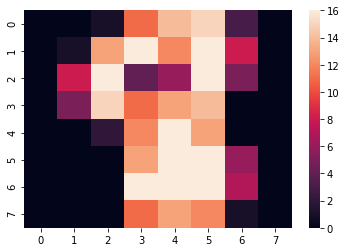

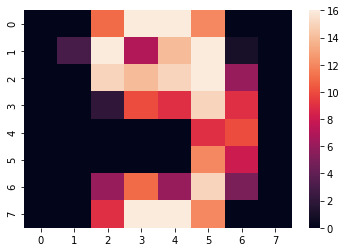

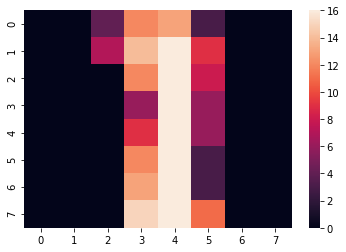

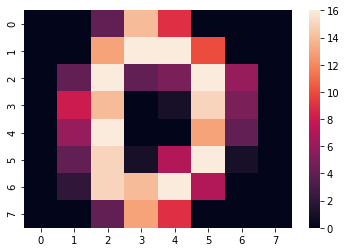

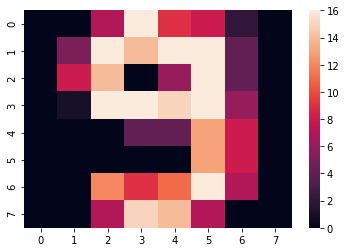

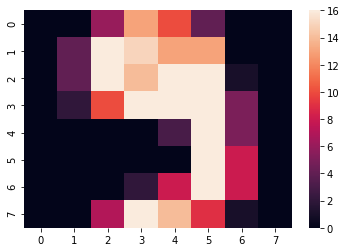

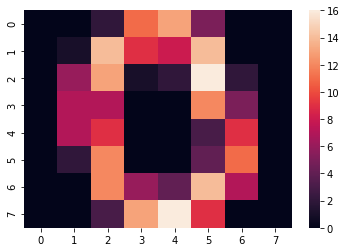

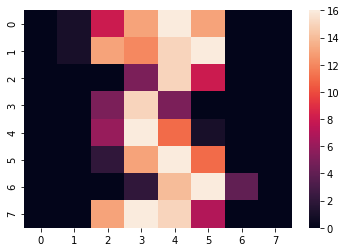

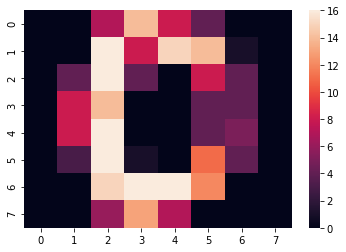

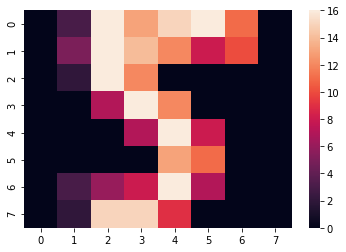

In [11]:
for i in range(0,10):
    plt.show(sns.heatmap(generatepixelarray(pixelsample,i,8,8)))

We hebben dus te maken met plaatjes van 8x8 grootte. Voor het gemak gaan we dus een Neuraal netwerk opzetten met 3 layers; de eerste layer is de input layer (deze heeft dus 64 neurons; in onze code is deze 'onzichtbaar'; het is de input van het netwerk), de tweede layer heeft twee keer zoveel neurons en de derde layer heeft 10 neurons (de outputlayer).

**Notitie: Deze dataset is al helemaal 'clean'; Data cleanup en Data preparation is hier niet nodig, deze stappen slaan we dus over. We zullen wel tijdens het organiseren van de testdata de data overzetten naar een list; kennelijk ontstaan er makkelijk errors als we direct een pandas dataframe gebruiken. Verder maken we ook dummies van y, zodat deze in ons netwerk passen.**

# Stap 3 - Model trainen
We gaan het bovengenoemde model in de realiteit brengen. Hiervoor hoeven we alleen nog onze features/targets organiseren en de train/test data.

In [12]:
frame

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        5.0       13.0        9.0        1.0   
1           0.0        0.0        0.0       12.0       13.0        5.0   
2           0.0        0.0        0.0        4.0       15.0       12.0   
3           0.0        0.0        7.0       15.0       13.0        1.0   
4           0.0        0.0        0.0        1.0       11.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        0.0        4.0       10.0       13.0        6.0   
1793        0.0        0.0        6.0       16.0       13.0       11.0   
1794        0.0        0.0        1.0       11.0       15.0        1.0   
1795        0.0        0.0        2.0       10.0        7.0        0.0   
1796        0.0        0.0       10.0       14.0        8.0        1.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0           0.0        0.0        0.0        0.0  ...        0.0        0.0   
1           0.0        0.0        0.0        0.0  ...        0.0        0.0   
2           0.0        0.0        0.0        0.0  ...        0.0        0.0   
3           0.0        0.0        0.0        8.0  ...        0.0        0.0   
4           0.0        0.0        0.0        0.0  ...        0.0        0.0   
...         ...        ...        ...        ...  ...        ...        ...   
1792        0.0        0.0        0.0        1.0  ...        0.0        0.0   
1793        1.0        0.0        0.0        0.0  ...        0.0        0.0   
1794        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1795        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1796        0.0        0.0        0.0        2.0  ...        0.0        0.0   

      pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0           0.0        6.0       13.0       10.0        0.0        0.0   
1           0.0        0.0       11.0       16.0       10.0        0.0   
2           0.0        0.0        3.0       11.0       16.0        9.0   
3           0.0        7.0       13.0       13.0        9.0        0.0   
4           0.0        0.0        2.0       16.0        4.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        2.0       14.0       15.0        9.0        0.0   
1793        0.0        6.0       16.0       14.0        6.0        0.0   
1794        0.0        2.0        9.0       13.0        6.0        0.0   
1795        0.0        5.0       12.0       16.0       12.0        0.0   
1796        1.0        8.0       12.0       14.0       12.0        1.0   

      pixel_7_7  target  
0           0.0       0  
1           0.0       1  
2           0.0       2  
3           0.0       3  
4           0.0       4  
...         ...     ...  
1792        0.0       9  
1793        0.0       0  
1794        0.0       8  
1795        0.0       9  
1796        0.0       8  

[1797 rows x 65 columns]

In [13]:
xframe = frame.drop("target",axis=1)
xframe

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        5.0       13.0        9.0        1.0   
1           0.0        0.0        0.0       12.0       13.0        5.0   
2           0.0        0.0        0.0        4.0       15.0       12.0   
3           0.0        0.0        7.0       15.0       13.0        1.0   
4           0.0        0.0        0.0        1.0       11.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        0.0        4.0       10.0       13.0        6.0   
1793        0.0        0.0        6.0       16.0       13.0       11.0   
1794        0.0        0.0        1.0       11.0       15.0        1.0   
1795        0.0        0.0        2.0       10.0        7.0        0.0   
1796        0.0        0.0       10.0       14.0        8.0        1.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
0           0.0        0.0        0.0        0.0  ...        0.0        0.0   
1           0.0        0.0        0.0        0.0  ...        0.0        0.0   
2           0.0        0.0        0.0        0.0  ...        5.0        0.0   
3           0.0        0.0        0.0        8.0  ...        9.0        0.0   
4           0.0        0.0        0.0        0.0  ...        0.0        0.0   
...         ...        ...        ...        ...  ...        ...        ...   
1792        0.0        0.0        0.0        1.0  ...        4.0        0.0   
1793        1.0        0.0        0.0        0.0  ...        1.0        0.0   
1794        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1795        0.0        0.0        0.0        0.0  ...        2.0        0.0   
1796        0.0        0.0        0.0        2.0  ...        8.0        0.0   

      pixel_7_0  pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  \
0           0.0        0.0        6.0       13.0       10.0        0.0   
1           0.0        0.0        0.0       11.0       16.0       10.0   
2           0.0        0.0        0.0        3.0       11.0       16.0   
3           0.0        0.0        7.0       13.0       13.0        9.0   
4           0.0        0.0        0.0        2.0       16.0        4.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        0.0        2.0       14.0       15.0        9.0   
1793        0.0        0.0        6.0       16.0       14.0        6.0   
1794        0.0        0.0        2.0        9.0       13.0        6.0   
1795        0.0        0.0        5.0       12.0       16.0       12.0   
1796        0.0        1.0        8.0       12.0       14.0       12.0   

      pixel_7_6  pixel_7_7  
0           0.0        0.0  
1           0.0        0.0  
2           9.0        0.0  
3           0.0        0.0  
4           0.0        0.0  
...         ...        ...  
1792        0.0        0.0  
1793        0.0        0.0  
1794        0.0        0.0  
1795        0.0        0.0  
1796        1.0        0.0  

[1797 rows x 64 columns]

In [14]:
processingx = xframe.values.tolist()
processingx

[[0.0,
  0.0,
  5.0,
  13.0,
  9.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  13.0,
  15.0,
  10.0,
  15.0,
  5.0,
  0.0,
  0.0,
  3.0,
  15.0,
  2.0,
  0.0,
  11.0,
  8.0,
  0.0,
  0.0,
  4.0,
  12.0,
  0.0,
  0.0,
  8.0,
  8.0,
  0.0,
  0.0,
  5.0,
  8.0,
  0.0,
  0.0,
  9.0,
  8.0,
  0.0,
  0.0,
  4.0,
  11.0,
  0.0,
  1.0,
  12.0,
  7.0,
  0.0,
  0.0,
  2.0,
  14.0,
  5.0,
  10.0,
  12.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.0,
  13.0,
  10.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  12.0,
  13.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  11.0,
  16.0,
  9.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.0,
  15.0,
  16.0,
  6.0,
  0.0,
  0.0,
  0.0,
  7.0,
  15.0,
  16.0,
  16.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  16.0,
  16.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  16.0,
  16.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  16.0,
  16.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  11.0,
  16.0,
  10.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  4.0,
  15.0,
  12.0,
  0.0,
  0.0,
  0.0,
  0.

In [15]:
def normalize(test:list):
    """Normalizes a given list."""
    minbound = min(test)
    maxbound = max(test)
    for i in range(len(test)):
        test[i] = (test[i] - minbound)/(maxbound - minbound)
    return test
x = [normalize(x) for x in processingx]
x

[[0.0,
  0.0,
  0.3333333333333333,
  0.8666666666666667,
  0.6,
  0.06666666666666667,
  0.0,
  0.0,
  0.0,
  0.0,
  0.8666666666666667,
  1.0,
  0.6666666666666666,
  1.0,
  0.3333333333333333,
  0.0,
  0.0,
  0.2,
  1.0,
  0.13333333333333333,
  0.0,
  0.7333333333333333,
  0.5333333333333333,
  0.0,
  0.0,
  0.26666666666666666,
  0.8,
  0.0,
  0.0,
  0.5333333333333333,
  0.5333333333333333,
  0.0,
  0.0,
  0.3333333333333333,
  0.5333333333333333,
  0.0,
  0.0,
  0.6,
  0.5333333333333333,
  0.0,
  0.0,
  0.26666666666666666,
  0.7333333333333333,
  0.0,
  0.06666666666666667,
  0.8,
  0.4666666666666667,
  0.0,
  0.0,
  0.13333333333333333,
  0.9333333333333333,
  0.3333333333333333,
  0.6666666666666666,
  0.8,
  0.0,
  0.0,
  0.0,
  0.0,
  0.4,
  0.8666666666666667,
  0.6666666666666666,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.75,
  0.8125,
  0.3125,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.6875,
  1.0,
  0.5625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1875,
  0.9375,
  1.0,
  0.

In [16]:
yframe = frame["target"]
yframe

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int32

In [17]:
y = pandas.get_dummies(yframe).values.tolist()
y

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0,

De dataset bevat 1797 plaatjes. Dit is teveel voor ons model om binnen een reeële tijd door heen te gaan (zelfs bij een epoch van 1 zit ik hier nog na 10 minuten te wachten...!). We kiezen er dus voor om de dataset in te perken. 

In [18]:
minbound = 0
maxbound = 1347
x, y = x[minbound:maxbound], y[minbound:maxbound]

In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [20]:
# print(len(yframe.unique()))

In [23]:
# Definitions
inputs = len(xframe.columns)  # Aantal features
outputs = len(yframe.unique())  # Aantal outputs
neurons = 128  # Aantal neurons in de eerste layer.
eta = 0.3 # Learning rate
epochs = 40  # Aantal keer dat het netwerk door de **hele** trainset heen loopt
errortolerance = 0.01  # Als de MSE onder deze grens ligt, dan houdt het netwerk op met trainen
random.seed(1756708)
# End of definitions
start = time.time()
l1 = NeuronLayer([])
l2 = NeuronLayer([])

for i in range(neurons):  # Tweede layer
    n = Neuron([random.random() for i in range(inputs)],Sigmoid().activate)
    l1.neurons.append(n)
    
for j in range(outputs):  # Output layer
    n = Neuron([random.random() for i in range(neurons)],Sigmoid().activate)
    l2.neurons.append(n)

ntwrk = NeuronNetwork([l1,l2],learningrate=eta)
ntwrk.train(x_train,y_train,epochs=epochs,errortreshold=errortolerance)
end = time.time()
print("Training network took {} seconds.".format((end-start)))

Feeding forward: 0.0 seconds
Backpropagating: 0.001947641372680664 seconds
Updating: 0.001947641372680664 seconds
Loop finished: 0.001947641372680664 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.002500772476196289 seconds
Updating: 0.002500772476196289 seconds
Loop finished: 0.002500772476196289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.0019936561584472656 seconds
Updating: 0.002991199493408203 seconds
Loop finished: 0.002991199493408203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 secon

Backpropagating: 0.000997304916381836 seconds
Updating: 0.0019958019256591797 seconds
Loop finished: 0.0019958019256591797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0059850215911865234 seconds
Updating: 0.0059850215911865234 seconds
Loop finished: 0.0059850215911865234 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0

Loop finished: 0.0009565353393554688 seconds
Feeding forward: 0.0009908676147460938 seconds
Backpropagating: 0.0009908676147460938 seconds
Updating: 0.0009908676147460938 seconds
Loop finished: 0.0009908676147460938 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.00099754333

Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop fin

Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0009658336639404297 seconds
Backpropagating: 0.0009658336639404297 seconds
Updating: 0.0009658336639404297 seconds
Loop finished: 0.0009658336639404297 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.002012968063354492 seconds
Updating: 0.002012968063354492 seconds
Loop finished: 0.0020129680

Feeding forward: 0.0010004043579101562 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.0010004043579101562 seconds
Feeding forward: 0.0009996891021728516 seconds
Backpropagating: 0.0009996891021728516 seconds
Updating: 0.0009996891021728516 seconds
Loop finished: 0.0009996891021728516 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009887218475341797 seconds
Updating: 0.0009887218475341797 seconds
Loop finished: 0.0009887218475341797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.0019555091857910156 seconds
Loop finished: 0.0019555091857910156 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Fee

Backpropagating: 0.0010349750518798828 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010328292846679688 seconds
Updating: 0.0010328292846679688 seconds
Loop finished: 0.0010328292846679688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009610652923583984 seconds
Updating: 0.0009610652923583984 seconds
Loop finished: 0.0009610652923583984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010416507720947266 seconds
Updating: 0.0010416507720947266 seconds
Loop finished: 0.0010416507720947266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009911060333251953 seconds
Updating: 0.0009911060333251953 seconds
Loop finished: 0.0009911060333251953 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000996112823486

Updating: 0.0009961128234863281 seconds
Loop finished: 0.0019936561584472656 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010340213775634766 seconds
Updating: 0.0010340213775634766 seconds
Loop finished: 0.0010340213775634766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009610652923583984 seconds
Updating: 0.0009610652923583984 seconds
Loop finished: 0.0009610652923583984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.01148533821105957 seconds
Updating: 0.012482881546020508 seconds
Loop finished: 0.012482881546020508 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 second

Backpropagating: 0.0009748935699462891 seconds
Updating: 0.0009748935699462891 seconds
Loop finished: 0.0009748935699462891 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward:

Loop finished: 0.0015034675598144531 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward:

Feeding forward: 0.0009925365447998047 seconds
Backpropagating: 0.0019927024841308594 seconds
Updating: 0.0019927024841308594 seconds
Loop finished: 0.0019927024841308594 seconds
Feeding forward: 0.0009944438934326172 seconds
Backpropagating: 0.0019593238830566406 seconds
Updating: 0.0019593238830566406 seconds
Loop finished: 0.0019593238830566406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feed

Backpropagating: 0.000997304916381836 seconds
Updating: 0.002240419387817383 seconds
Loop finished: 0.002240419387817383 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000986337661743164 seconds
Updating: 0.000986337661743164 seconds
Loop finished: 0.000986337661743164 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010356903076171875 seconds
Updating: 0.0010356903076171875 seconds
Loop finished: 0.0010356903076171875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.00

Backpropagating: 0.000997304916381836 seconds
Updating: 0.002008676528930664 seconds
Loop finished: 0.002008676528930664 seconds
Feeding forward: 0.0009844303131103516 seconds
Backpropagating: 0.0009844303131103516 seconds
Updating: 0.0009844303131103516 seconds
Loop finished: 0.0009844303131103516 seconds
Feeding forward: 0.0010387897491455078 seconds
Backpropagating: 0.0010387897491455078 seconds
Updating: 0.0010387897491455078 seconds
Loop finished: 0.0010387897491455078 seconds
Feeding forward: 0.000995635986328125 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009565353393554688 seconds
Updating: 0.0009565353393554688 seconds
Loop finished: 0.0009565353393554688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009984970092773438 seconds
Updating: 0.0009984970092773438 seconds
Loop finished: 0.0009984970092773438 seconds
Feeding forward:

Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0019943714141845703 seconds
Updating: 0.0019943714141845703 seconds
Loop finished: 0.0019943714141845703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010223388671875 seconds
Updating: 0.0010223388671875 seconds
Loop finished: 0

Feeding forward: 0.0010292530059814453 seconds
Backpropagating: 0.0022115707397460938 seconds
Updating: 0.0032355785369873047 seconds
Loop finished: 0.0032355785369873047 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0005328655242919922 seconds
Updating: 0.0005328655242919922 seconds
Loop finished: 0.0005328655242919922 seconds
Feeding forward: 0.0005908012390136719 seconds
Backpropagating: 0.0005908012390136719 seconds
Updating: 0.0005908012390136719 seconds
Loop finished: 0.0005908012390136719 seconds
Feeding forward: 0.0009615421295166016 seconds
Backpropagating: 0.0009615421295166016 seconds
Updating: 0.0009615421295166016 seconds
Loop finished: 0.0009615421295166016 seconds
Feeding forward: 0.0010058879852294922 seconds
Backpropagating: 0.0010058879852294922 seconds
Updating: 0.0010058879852294922 seconds
Loop finished: 0.0010058879852294922 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009655952453613281 seconds
Updating: 0.0009655952453613281 seconds
Loop fi

Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009937286376953125 seconds
Backpropagating: 0.0009937286376953125 seconds
Updating: 0.0009937286376953125 seconds
Loop finished: 0.0009937286376953125 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009946823120117188 seconds
Backpropagating: 0.0009946823120117188 seconds
Updating: 0.002950906753540039 seconds
Loop finished: 0.002950906753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 

Feeding forward: 0.0010037422180175781 seconds
Backpropagating: 0.002991199493408203 seconds
Updating: 0.002991199493408203 seconds
Loop finished: 0.002991199493408203 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding f

Backpropagating: 0.0009524822235107422 seconds
Updating: 0.0019490718841552734 seconds
Loop finished: 0.0019490718841552734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010285377502441406 seconds
Updating: 0.0010285377502441406 seconds
Loop finished: 0.0010285377502441406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009675025939941406 seconds
Updating: 0.0009675025939941406 seconds
Loop finished: 0.0009675025939941406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010101795196533203 seconds
Updating: 0.0010101795196533203 seconds
Loop finished: 0.0010101795196533203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039

Backpropagating: 0.000997781753540039 seconds
Updating: 0.002031564712524414 seconds
Loop finished: 0.002031564712524414 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009615421295166016 seconds
Updating: 0.0009615421295166016 seconds
Loop finished: 0.0009615421295166016 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0009963512420654297 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backp

Backpropagating: 0.0019953250885009766 seconds
Updating: 0.0019953250885009766 seconds
Loop finished: 0.0019953250885009766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010335445404052734 seconds
Updating: 0.001996755599975586 seconds
Loop finished: 0.001996755599975586 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010256767272949219 seconds
Updating: 0.0010256767272949219 seconds
Loop finished: 0.0010256767272949219 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000995635986328125 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop fini

Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.000997304916381836 seconds
Ba

Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0019958019256591797 seconds
Upd

Backpropagating: 0.001026153564453125 seconds
Updating: 0.03594708442687988 seconds
Loop finished: 0.03594708442687988 seconds
Feeding forward: 0.001016378402709961 seconds
Backpropagating: 0.001016378402709961 seconds
Updating: 0.001016378402709961 seconds
Loop finished: 0.0019941329956054688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0009989738464355469 seconds
Loop finished: 0.0009989738464355469 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009953975677490234 seconds
Updating: 0.0009953975677490234 seconds
Loop finished: 0.0009953975677490234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 sec

Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009982585906982422 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009980201721191406 seconds
B

Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.00099

Feeding forward: 0.0 seconds
Backpropagating: 0.00102996826171875 seconds
Updating: 0.00102996826171875 seconds
Loop finished: 0.00102996826171875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010056495666503906 seconds
Updating: 0.0010056495666503906 seconds
Loop finished: 0.0010056495666503906 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0009999275207519531 seconds
Loop finished: 0.0009999275207519531 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009930133819580078 seconds
Updating: 0.0009930133819580078 seconds
Loop finished: 0.0009930133819580078 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010013580322265625 seconds
Loop finished: 0.0010013580322265625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000989675521850586 seconds
Backpropagating: 0.0019512176513671875 seconds
Updating: 0.0019512

Updating: 0.0009949207305908203 seconds
Loop finished: 0.0019931793212890625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds

Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0

Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009996891021728516 seconds
Updating: 0.0009996891021728516 seconds
Loop finished: 0.0009996891021728516 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0009961128234863281 seconds
Feeding forward: 0.0 seconds
Ba

Updating: 0.0 seconds
Loop finished: 0.001995563507080078 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.001995086669921875 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0

Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0030007362365722656 seconds
Updating: 0.003987550735473633 seconds
Loop finished: 0.003987550735473633 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
B

Backpropagating: 0.0029926300048828125 seconds
Updating: 0.0029926300048828125 seconds
Loop finished: 0.0029926300048828125 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward:

Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.001994609832763672 seconds
Loop finished: 0.001994609832763672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0010123252868652344 seconds
Backpropagat

Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Upda

Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0019643306732177734 seconds
Loop finished: 0.0019643306732177734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009913444519042969 seconds
Updating: 0.0009913444519042969 seconds
Loop finished: 0.0009913444519042969 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating:

Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0009961128234863281 seconds
Backpropagating: 0.009973287582397461 seconds
Updating: 0.009973287582397461 seconds
Loop finished: 0.009973287582397461 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.0009

Updating: 0.001961231231689453 seconds
Loop finished: 0.001961231231689453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009

Backpropagating: 0.000997304916381836 seconds
Updating: 0.001995563507080078 seconds
Loop finished: 0.001995563507080078 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0019948482513427734 seconds

Loop finished: 0.0019953250885009766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.001016378402709961 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds

Feeding forward: 0.0 seconds
Backpropagating: 0.005985260009765625 seconds
Updating: 0.005985260009765625 seconds
Loop finished: 0.005985260009765625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds


Feeding forward: 0.0010006427764892578 seconds
Backpropagating: 0.0010006427764892578 seconds
Updating: 0.0010006427764892578 seconds
Loop finished: 0.0010006427764892578 seconds
Feeding forward: 0.00099945068359375 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.00099945068359375 seconds
Loop finished: 0.00099945068359375 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0009989738464355469 seconds
Loop finished: 0.0009989738464355469 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009953975677490234 seconds
Updating: 0.0009953975677490234 seconds
Loop finished: 0.0009953975677490234 seconds
Feeding forward: 0.0009605884552001953 seconds
Backpropagating: 0.0009605884552001953 seconds
Updating: 0.0009605884552001953 seconds
Loop finished: 0.00

Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001995086669921875 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 sec

Updating: 0.0009987354278564453 seconds
Loop finished: 0.001992464065551758 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009655952453613281 seconds
Updating: 0.0009655952453613281 seconds
Loop finished: 0.0009655952453613281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009989738464355469 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0009989738464355469 seconds
Loop finished: 0.0009989738464355469 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.00099802

Feeding forward: 0.0 seconds
Backpropagating: 0.0009663105010986328 seconds
Updating: 0.0009663105010986328 seconds
Loop finished: 0.0009663105010986328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0010104179382324219 seconds
Backpropagating: 0.001992464065551758 seconds
Updating: 0.001992464065551758 seconds
Loop finished: 0.001992464065551758 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feed

Backpropagating: 0.00498652458190918 seconds
Updating: 0.00498652458190918 seconds
Loop finished: 0.00498652458190918 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010094642639160156 seconds
Updating: 0.0010094642639160156 seconds
Loop finished: 0.0010094642639160156 seconds
Feeding forward: 0.0010006427764892578 seconds
Backpropagating: 0.001981973648071289 seconds
Updating: 0.001981973648071289 seconds
Loop finished: 0.001981973648071289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0019960403442382812 seconds
Updating: 0.0019960403442382812 seconds
Loop finished: 0.0019960403442382812 seconds
Feeding forward: 0.0009961128234863281 seconds
Backpropagating: 0.0009961128234863281 seconds
Updating: 0.0009961128234863281 seconds
Loop finished: 0.0009961128234863281 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0

Feeding forward: 0.0 seconds
Backpropagating: 0.0010013580322265625 seconds
Updating: 0.0010013580322265625 seconds
Loop finished: 0.0010013580322265625 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009677410125732422 seconds
Backpropagating: 0.0009677410125732422 seconds
Updating: 0.001964092254638672 seconds
Loop finished: 0.001964092254638672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropaga

Feeding forward: 0.0 seconds
Backpropagating: 0.0010025501251220703 seconds
Updating: 0.0010025501251220703 seconds
Loop finished: 0.0010025501251220703 seconds
Feeding forward: 0.0009918212890625 seconds
Backpropagating: 0.0009918212890625 seconds
Updating: 0.0009918212890625 seconds
Loop finished: 0.0009918212890625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010001659393310547 seconds
Updating: 0.0010001659393310547 seconds
Loop finished: 0.0010001659393310547 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009944438934326172 seconds
Updating: 0.0009944438934326172 seconds
Loop finished: 0.0009944438934326172 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds

Loop finished: 0.0030298233032226562 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010030269622802734 seconds
Updating: 0.0010030269622802734 seconds
Loop finished: 0.0010030269622802734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010020732879638672 seconds
Updating: 0.0010020732879638672 seconds
Loop finished: 0.0010020732879638672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009932518005371094 seconds
Updating: 0.0009932518005371094 seconds
Loop finished: 0.0009932518005371094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010023117065429688 seconds
Updating: 0.0010023117065429688 seconds
Loop finished: 0.0010023117065429688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009913444519042969 seconds
Updating: 0.0009913444519042969 seconds
Loop finished: 0.0009913444519042969 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009548664093017578 seconds
Updating: 0.0009548664093017578 seconds
Loop finished: 0.00095486640930175

Feeding forward: 0.0 seconds
Backpropagating: 0.0010280609130859375 seconds
Updating: 0.002024412155151367 seconds
Loop finished: 0.002024412155151367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010242462158203125 seconds
Loop finished: 0.0010242462158203125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009751319885253906 seconds
Updating: 0.0009751319885253906 seconds
Loop finished: 0.0009751319885253906 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001959085464477539 seconds
Updating: 0.001959085464477539 seconds
Loop finished: 0.001959085464477539 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997066

Feeding forward: 0.0 seconds
Backpropagating: 0.0010297298431396484 seconds
Updating: 0.0010297298431396484 seconds
Loop finished: 0.0010297298431396484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010025501251220703 seconds
Updating: 0.0010025501251220703 seconds
Loop finished: 0.0010025501251220703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000990152359008789 seconds
Updating: 0.000990152359008789 seconds
Loop finished: 0.000990152359008789 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009920597076416016 seconds
Updating: 0.0009920597076416016 seconds
Loop finished: 0.0009920597076416016 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009908676147460938 seconds
Updating: 0.0009908676147460938 seconds
Loop finished: 0.0009908676147460938 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010128021240234375 seconds
Updating: 0.0010128021240234375 seconds
Loop finished: 0.0010128021240234375 seconds
Feeding forward: 0.0 seconds
Backprop

Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.001995086669921875 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.00

Loop finished: 0.0010330677032470703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009992122650146484 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0010120868682861328 seconds
Backpropagating: 0.0010120868682861328 seconds
Updating: 0.0010120868682861328 seconds
Loop finished: 0.0010120868682861328 seconds
Feeding forward: 0.0009927749633789062 seconds
Backpropagating: 0.0009927749633789062 seconds
Updating: 0.0009927749633789062 seconds
Loop finished: 0.0009927749633789062 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009844303131103516 seconds
Updating: 0.0009844303131103516 seconds
Loop finished: 0.0009844303131103516 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010094642639160156 seconds
Updating: 0.0010094642639160156 seconds
Loop finished: 0.00100946426391601

Backpropagating: 0.0 seconds
Updating: 0.000972747802734375 seconds
Loop finished: 0.000972747802734375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010218620300292969 seconds
Updating: 0.0010218620300292969 seconds
Loop finished: 0.0010218620300292969 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0009989738464355469 seconds
Loop finished: 0.0009989738464355469 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.000972747802734375 seconds
Backpropagating: 0.0019690990447998047 seconds
Updating: 0.0019690990447998047 seconds
Loop finished: 0.0019690990447998047 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997066497802734

Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968

Backpropagating: 0.000990152359008789 seconds
Updating: 0.0019495487213134766 seconds
Loop finished: 0.0019495487213134766 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010411739349365234 seconds
Updating: 0.0010411739349365234 seconds
Loop finished: 0.0010411739349365234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009534358978271484 seconds
Updating: 0.0009534358978271484 seconds
Loop finished: 0.0009534358978271484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010333061218261719 seconds
Updating: 0.0010333061218261719 seconds
Loop finished: 0.0010333061218261719 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009617805480957031 seconds
Updating: 0.0009617805480957031 seconds
Loop finished: 0.0009617805480957031 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00

Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0009601116180419922 seconds
Backpropagating: 0.0009601116180419922 seconds
Updating: 0.0009601116180419922 seconds
Loop finished: 0.0009601116180419922 seconds
Feeding forward: 0.001032114028930664 seconds
Backpropagating: 0.001032114028930664 seconds
Updating: 0.001032114028930664 seconds
Loop finished: 0.001032114028930664 seconds
Feeding forward: 0.0009984970092773438 seconds
Backpropagating: 0.0009984970092773438 seconds
Updating: 0.0009984970092773438 seconds
Loop finished: 0.0009984970092773438 seconds
Feeding forward: 0.0009944438934326172 seconds
Backpropagating: 0.0009944438934326172 seconds
Updating: 0.0009944438934326172 s

Feeding forward: 0.0 seconds
Backpropagating: 0.0009872913360595703 seconds
Updating: 0.0009872913360595703 seconds
Loop finished: 0.0009872913360595703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.001001119613647461 seconds
Backpropagating: 0.001001119613647461 seconds
Updating: 0.001001119613647461 seconds
Loop finished: 0.001001119613647461 seconds
Feeding forward: 0.0010395050048828125 seconds
Backpropagating: 0.0010395050048828125 seconds
Updating: 0.0010395050048828125 seconds
Loop finished: 0.0010395050048828125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009953975677490234 seconds
U

Backpropagating: 0.0010263919830322266 seconds
Updating: 0.0020253658294677734 seconds
Loop finished: 0.0020253658294677734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009813308715820312 seconds
Updating: 0.0009813308715820312 seconds
Loop finished: 0.0009813308715820312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001016855239868164 seconds
Updating: 0.001016855239868164 seconds
Loop finished: 0.001016855239868164 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009951591491699219 seconds
Updating: 0.0009951591491699219 seconds
Loop finished: 0.0009951591491699219 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009677410125732422 seconds
Updating: 0.0009677410125732422 seconds
Loop finished: 0.0009677410125732422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001030921936035156

Feeding forward: 0.0 seconds
Backpropagating: 0.0019974708557128906 seconds
Updating: 0.0029954910278320312 seconds
Loop finished: 0.0029954910278320312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009984970092773438 seconds
Loop finished: 0.0009984970092773438 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010006427764892578 seconds
Backpropagating: 0.0010006427764892578 seconds
Updating: 0.0010006427764892578 seconds
Loop finished: 0.0010006427764892578 seconds
Feeding forward: 0.0009944438934326172 seconds
Backpropagating: 0.0009944438934326172 seconds
Updating: 0.0009944438934326172 seconds
Loop finished: 0.0009944438934326172 seconds
Feeding forward: 0.0009992122650146484 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009

Loop finished: 0.001991748809814453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010020732879638672 seconds
Loop finished: 0.0010020732879638672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010004043579101562 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.0010004043579101562 seconds
Feeding forward: 0.0009937286376953125 seconds
Backpropagating: 0.0009937286376953125 seconds
Updating: 0.0009937286376953125 seconds
Loop finished: 0.0009937286376953125 seconds
Feeding forward: 0.0009605884552001953 seconds
Backpropagating: 0.0009605884552001953 seconds
Updating: 0.0009605884552001953 seconds
Loop finished: 0.0009605884552001953 seconds
Feeding 

Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010406970977783203 seconds
Updating: 0.0010406970977783203 seconds
Loop finished: 0.0010406970977783203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009932518005371094 seconds
Loop finished: 0.0009932518005371094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009582042694091797 seconds
Backpropagating: 0.0009582042694091797 seconds
Updating: 0.0009582042694091797 seconds
Loop finished: 0.0009582042694091797 seconds
Feeding forward: 0.0010061264038085938 seconds
Backpropagating: 0.0010061264038085938 seconds
Updating: 0.0010061264038085938 seconds
Loop finished: 0.0010061264038085938 seconds
Feeding forward: 0.000988006591796875 seconds
Backpropagating: 0.00098

Loop finished: 0.010953664779663086 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010044574737548828 seconds
Updating: 0.0010044574737548828 seconds
Loop finished: 0.0010044574737548828 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009944438934326172 seconds
Updating: 0.0009944438934326172 seconds
Loop finished: 0.0009944438934326172 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.001001119613647461 seconds
Loop finished: 0.001001119613647461 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009577274322509766 seconds
Updating: 0.0009577274322509766 seconds
Loop finished: 0.0009577274322509766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010404586791992188 seconds
Updating: 0.0010404586791992188 seconds
Loop finished: 0.0010404586791992188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding fo

Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000995635986328125 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.000997781753540039 se

Backpropagating: 0.0010340213775634766 seconds
Updating: 0.0019953250885009766 seconds
Loop finished: 0.0019953250885009766 seconds
Feeding forward: 0.0009992122650146484 seconds
Backpropagating: 0.001993894577026367 seconds
Updating: 0.001993894577026367 seconds
Loop finished: 0.001993894577026367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00102996826171875 seconds
Updating: 0.00102996826171875 seconds
Loop finished: 0.00102996826171875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000993490

Loop finished: 0.0009942054748535156 seconds
Feeding forward: 0.000989675521850586 seconds
Backpropagating: 0.000989675521850586 seconds
Updating: 0.000989675521850586 seconds
Loop finished: 0.0019559860229492188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001035928726196289 seconds
Updating: 0.001035928726196289 seconds
Loop finished: 0.001035928726196289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0009915828704833984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.001008749008178711 seconds
Backpropagating: 0.001008749008178711 seconds
Updating: 0.001008749008178711 seconds
Loop finished: 0.001008749008178711 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00101

Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.00099945068359375 seconds
Loop finished: 0.00099945068359375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009942054748535156 seconds
Updating: 0.0009942054748535156 seconds
Loop finished: 0.0009942054748535156 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.001958608627319336 seconds
Feeding forward: 0.0010287761688232422 seconds
Backpropagating: 0.002000570297241

Loop finished: 0.004984617233276367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009951591491699219 seconds
Updating: 0.0009951591491699219 seconds
Loop finished: 0.0009951591491699219 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0009999275207519531 seconds
Loop finished: 0.0009999275207519531 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.000995874404907226

Updating: 0.001957416534423828 seconds
Loop finished: 0.001957416534423828 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010328292846679688 seconds
Updating: 0.0010328292846679688 seconds
Loop finished: 0.0010328292846679688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009620189666748047 seconds
Updating: 0.0009620189666748047 seconds
Loop finished: 0.0009620189666748047 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010344982147216797 seconds
Updating: 0.0010344982147216797 seconds
Loop finished: 0.0010344982147216797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009951591491699219 seconds
Updating: 0.001957416534423828 seconds
Loop finished: 0.001957416534423828 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010082721710205078 seconds
Updating: 0.0020079612731933594 seconds
Loop finished: 0.0020079612731933594 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010149478912353516 seconds
Updating: 0.0010149478912353516 second

Backpropagating: 0.0009942054748535156 seconds
Updating: 0.004018068313598633 seconds
Loop finished: 0.004018068313598633 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001010894775390625 seconds
Updating: 0.001010894775390625 seconds
Loop finished: 0.001010894775390625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010008811950683594 seconds
Updating: 0.0010008811950683594 seconds
Loop finished: 0.0010008811950683594 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009915828704833984 seconds
Updating: 0.0009915828704833984 seconds
Loop finished: 0.0009915828704833984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009996891021728516 seconds
Loop finished: 0.0009996891021728516 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009889602661132812 seconds
Backpropagating: 0.0009889602661132812 seconds
Updating: 0.0009889602661132812 seconds
Loop f

Updating: 0.0019576549530029297 seconds
Loop finished: 0.003106832504272461 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0008788108825683594 seconds
Updating: 0.0008788108825683594 seconds
Loop finished: 0.0008788108825683594 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0006227493286132812 seconds
Updating: 0.0006227493286132812 seconds
Loop finished: 0.0006227493286132812 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009572505950927734 seconds
Updating: 0.0009572505950927734 seconds
Loop finished: 0.0009572505950927734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feed

Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.004987239837646484 seconds
Loop finished: 0.004987239837646484 seconds
Feeding forward: 0.0 seconds
Backpropaga

Backpropagating: 0.0009984970092773438 seconds
Updating: 0.002007722854614258 seconds
Loop finished: 0.002007722854614258 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009903907775878906 seconds
Updating: 0.0009903907775878906 seconds
Loop finished: 0.0009903907775878906 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010344982147216797 seconds
Updating: 0.0010344982147216797 seconds
Loop finished: 0.0010344982147216797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009930133819580078 seconds
Updating: 0.0009930133819580078 seconds
Loop finished: 0.0009930133819580078 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.0010004043579101562 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000993490219116211 seconds
Updating: 0.000993490219116211 seconds
Loop finished: 0.000993490219116211 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 

Feeding forward: 0.0 seconds
Backpropagating: 0.0010044574737548828 seconds
Updating: 0.0010044574737548828 seconds
Loop finished: 0.0010044574737548828 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010018348693847656 seconds
Updating: 0.0010018348693847656 seconds
Loop finished: 0.0010018348693847656 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000993967056274414 seconds
Updating: 0.000993967056274414 seconds
Loop finished: 0.000993967056274414 seconds
Feeding forward: 0.0 seconds
Backprop

Updating: 0.002028942108154297 seconds
Loop finished: 0.002028942108154297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.01891303062438965 seconds
Loop finished: 0.01891303062438965 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009927749633789062 seconds
Loop finished: 0.0009927749633789062 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0009925365447998047 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0010101795196533203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000986337661743164 seconds
Backpropagating: 0.000986337661743164 seconds
Updatin

Feeding forward: 0.0 seconds
Backpropagating: 0.0009944438934326172 seconds
Updating: 0.0009944438934326172 seconds
Loop finished: 0.0009944438934326172 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001005411148071289 seconds
Updating: 0.001005411148071289 seconds
Loop finished: 0.001005411148071289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010101795196533203 seconds
Loop finished: 0.0010101795196533203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009849071502685547 seconds
Backpropagating: 0.0009849071502685547 seconds
Updating: 0.0009849071502685547 seconds
Loop finished: 0.0009849071502685547 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0019664764404296875 seconds
Updating: 0.0019664764404296875 seconds
Loop finished: 0.0019664764404296875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010187625885009766 s

Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.0020143985748291016 seconds
Updating: 0.0020143985748291016 seconds
Loop finished: 0.0020143985748291016 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009894371032714844 seconds
Updating: 0.0009894371032714844 seconds
Loop finished: 0.0009894371032714844 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009856224060058594 seconds
Updating: 0.0009856224060058594 seconds
Loop finished: 0.0009856224060058594 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009834766387939453 seconds
Loop finished: 0.0009834766387939453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0009973049163818

Loop finished: 0.0010266304016113281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001018524169921875 seconds
Updating: 0.001018524169921875 seconds
Loop finished: 0.001018524169921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009753704071044922 seconds
Updating: 0.0009753704071044922 seconds
Loop finished: 0.0009753704071044922 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009667873382568359 seconds
Updating: 0.0009667873382568359 seconds
Loop finished: 0.0009667873382568359 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 

Loop finished: 0.0009961128234863281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010039806365966797 seconds
Updating: 0.0010039806365966797 seconds
Loop finished: 0.0010039806365966797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009903907775878906 seconds
Updating: 0.0009903907775878906 seconds
Loop finished: 0.0009903907775878906 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.00099945068359375 seconds
Loop finished: 0.00099945068359375 seconds
Feeding forward: 0.0009615421295166016 seconds
Backpropagating: 0.001993894577026367 seconds
Updating: 0.001993894577026367 seconds
Loop finished: 0.001993894577026367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.00100040

Feeding forward: 0.0010287761688232422 seconds
Backpropagating: 0.0020189285278320312 seconds
Updating: 0.0020189285278320312 seconds
Loop finished: 0.0020189285278320312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010037422180175781 seconds
Updating: 0.0010037422180175781 seconds
Loop finished: 0.0010037422180175781 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009915828704833984 seconds
Updating: 0.0009915828704833984 seconds
Loop finished: 0.0009915828704833984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009949207305908203 seconds
Updating: 0.0009949207305908203 seconds
Loop finished: 0.0009949207305908203 seconds
Feeding forward:

Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009610652923583984 seconds
Backpropagating: 0.0009610652923583984 seconds
Updating: 0.0009610652923583984 seconds
Loop finished: 0.0009610652923583984 seconds
Feeding forward: 0.0010211467742919922 seconds
Backpropagating: 0.0010211467742919922 seconds
Updating: 0.0010211467742919922 seconds
Loop finished: 0.0010211467742919922 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010044574737548828 seconds
Backpropagating: 0.0010044574737548828 seconds
Updating: 0.0010044574737548828 seconds
Loop finished: 0.0010044574737548828 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009894371032714844 seconds
Updating: 0.0009894371032714844 seconds
Loop finished: 0.0009894371032714844 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010044574737548828 seconds
Updating: 0.0010044574737548828 seconds
Loop finished: 0.00100445747375488

Feeding forward: 0.0 seconds
Backpropagating: 0.0009942054748535156 seconds
Updating: 0.0009942054748535156 seconds
Loop finished: 0.0009942054748535156 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009984970092773438 seconds
Updating: 0.0009984970092773438 seconds
Loop finished: 0.0009984970092773438 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009963512420654297 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0009999275207519531 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0009999275207519531 seconds
Loop finished: 0.0009999275207519531 seconds
Feeding forward: 0.0009951591491699219 seconds
Backp

Loop finished: 0.0019965171813964844 seconds
Feeding forward: 0.0009670257568359375 seconds
Backpropagating: 0.0009670257568359375 seconds
Updating: 0.0019567012786865234 seconds
Loop finished: 0.0019567012786865234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001035451889038086 seconds
Updating: 0.001035451889038086 seconds
Loop finished: 0.001035451889038086 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009713172912597656 seconds
Loop finished: 0.0009713172912597656 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010211467742919922 seconds
Loop finished: 0.0010211467742919922 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010149478912353516 seconds
Backpropagating: 

Updating: 0.0009551048278808594 seconds
Loop finished: 0.0019936561584472656 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.0010004043579101562 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009915828704833984 seconds
Updating: 0.0009915828704833984 seconds
Loop finished: 0.0009915828704833984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010006427764892578 seconds
Updating: 0.0010006427764892578 seconds
Loop finished: 0.0010006427764892578 seconds
Feeding forward: 0.0009565353393554688 seconds
Backpropagating: 0.0009565353393554688 seconds
Updating: 0.0009565353393554688 seconds
Loop finished: 0.0009565353393554688 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0010366439819335938 seconds
Backpropagating: 0.00103664

Feeding forward: 0.0010039806365966797 seconds
Backpropagating: 0.0010039806365966797 seconds
Updating: 0.0010039806365966797 seconds
Loop finished: 0.0010039806365966797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009937286376953125 seconds
Updating: 0.0009937286376953125 seconds
Loop finished: 0.0009937286376953125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009913444519042969 seconds
Updating: 0.0009913444519042969 seconds
Loop finished: 0.0009913444519042969 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001001596450805664 seconds
Updating: 0.001001596450805664 seconds
Loop finished: 0.001001596450805664 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.

Backpropagating: 0.001032114028930664 seconds
Updating: 0.0019936561584472656 seconds
Loop finished: 0.0019936561584472656 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010302066802978516 seconds
Updating: 0.0010302066802978516 seconds
Loop finished: 0.0010302066802978516 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009596347808837891 seconds
Updating: 0.0009596347808837891 seconds
Loop finished: 0.0009596347808837891 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001033782958984375 seconds
Updating: 0.001033782958984375 seconds
Loop finished: 0.001033782958984375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating:

Feeding forward: 0.0 seconds
Backpropagating: 0.000990152359008789 seconds
Updating: 0.000990152359008789 seconds
Loop finished: 0.000990152359008789 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009961128234863281 seconds
Loop finished: 0.0009961128234863281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009522438049316406 seconds
Updating: 0.0009522438049316406 seconds
Loop finished: 0.0009522438049316406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009860992431640625 seconds
Updating: 0.0009860992431640625 seconds
Loop finished: 0.0009860992431640625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 sec

Feeding forward: 0.0 seconds
Backpropagating: 0.0010313987731933594 seconds
Updating: 0.0010313987731933594 seconds
Loop finished: 0.0010313987731933594 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0009999275207519531 seconds
Loop finished: 0.0009999275207519531 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0012407302856445312 seconds
Updating: 0.0012407302856445312 sec

Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00102996826171875 seconds
Updating: 0.00102996826171875 seconds
Loop finished: 0.00102996826171875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009961128234863281 seconds
Updating: 0.0009961128234863281 seconds
Loop finished: 0.0009961128234863281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009655952453613281 seconds
Updating: 0.0009655952453613281 seconds
Loop finished: 0.0009655952453613281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0020308494567871094 seconds
Updating: 0.0020308494567871094 seconds
Loop finished: 0.0020308494567871094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001958131790161133 seconds
Updating: 0.001958131790161133 seconds
Loop finished: 0.001958131790161133 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop fi

Feeding forward: 0.00098419189453125 seconds
Backpropagating: 0.00098419189453125 seconds
Updating: 0.00098419189453125 seconds
Loop finished: 0.00098419189453125 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0010046958923339844 seconds
Backpropagating: 0.0010046958923339844 seconds
Updating: 0.0010046958923339844 seconds
Loop finished: 0.0010046958923339844 seconds
Feeding forward: 0.0009963512420654297 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0009546279907226562 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
L

Updating: 0.0029604434967041016 seconds
Loop finished: 0.0029604434967041016 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0010089874267578125 seconds
Backpropagating: 0.001994609832763672 seconds
Updating: 0.001994609832763672 seconds
Loop finished: 0.001994609832763672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.000997304916381836 seconds
Loop

Feeding forward: 0.0 seconds
Backpropagating: 0.003988027572631836 seconds
Updating: 0.003988027572631836 seconds
Loop finished: 0.003988027572631836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating:

Feeding forward: 0.0 seconds
Backpropagating: 0.000989675521850586 seconds
Updating: 0.000989675521850586 seconds
Loop finished: 0.000989675521850586 seconds
Feeding forward: 0.0009958744049072266 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0009942054748535156 seconds
Backpropagating: 0.0009942054748535156 seconds
Updating: 0.0009942054748535156 seconds
Loop finished: 0.0009942054748535156 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010023117065429688 seconds
Updating: 0.0010023117065429688 seconds
Loop finished: 0.0010023117065429688 seconds
Feeding forward: 0.0009660720825195312 seconds
Backpropagating: 0.001962900161743164 seconds
Updating: 0.002961874008178711 seconds
Loop finished: 0.002961874008178711 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010225772857666016 seconds
Updating: 0.0010225772857666016 seconds
Loop finished: 0.00102257728576

Feeding forward: 0.0 seconds
Backpropagating: 0.0010263919830322266 seconds
Updating: 0.0010263919830322266 seconds
Loop finished: 0.0010263919830322266 seconds
Feeding forward: 0.0009937286376953125 seconds
Backpropagating: 0.0009937286376953125 seconds
Updating: 0.0009937286376953125 seconds
Loop finished: 0.0009937286376953125 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.001009225845336914 seconds
Backpropagating: 0.001009225845336914 seconds
Updating: 0.001009225845336914 seconds
Loop finished: 0.001009225845336914 seconds
Feeding forward: 0.0010025501251220703 seconds
Backpropagating: 0.0010025501251220703 seconds
Updating: 0.0010025501251220703 seconds
Loop finished: 0.0010025501251220703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009915828704833984 seconds
Updating: 0.0009915828704833984 seconds
Loop finish

Updating: 0.0010349750518798828 seconds
Loop finished: 0.0020346641540527344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009982585906982422 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feedin

Backpropagating: 0.0010349750518798828 seconds
Updating: 0.0010349750518798828 seconds
Loop finished: 0.0010349750518798828 seconds
Feeding forward: 0.0009951591491699219 seconds
Backpropagating: 0.0009951591491699219 seconds
Updating: 0.0009951591491699219 seconds
Loop finished: 0.0009951591491699219 seconds
Feeding forward: 0.0009925365447998047 seconds
Backpropagating: 0.0009925365447998047 seconds
Updating: 0.0009925365447998047 seconds
Loop finished: 0.0009925365447998047 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0010385513305664062 seconds
Backpropagating: 0.0010385513305664062 seconds
Updating: 0.0010385513305664062 seconds
Loop finished: 0.0010385513305664062 seconds
Feeding forward: 0.0009660720825195312 seconds
Backpropagating: 0.0009660720825195312 seconds
Updating: 0.0009660720825195312 seconds
Loop finished: 0.0009660720825195312

Feeding forward: 0.0010225772857666016 seconds
Backpropagating: 0.0010225772857666016 seconds
Updating: 0.0010225772857666016 seconds
Loop finished: 0.0010225772857666016 seconds
Feeding forward: 0.0009722709655761719 seconds
Backpropagating: 0.0009722709655761719 seconds
Updating: 0.0009722709655761719 seconds
Loop finished: 0.0009722709655761719 seconds
Feeding forward: 0.0009965896606445312 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009982585906982422 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0010213851928710938 seconds
Backpropagating: 0.0010213851928710938 seconds
Updating: 0.001

Loop finished: 0.0009648799896240234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010294914245605469 seconds
Updating: 0.0010294914245605469 seconds
Loop finished: 0.0010294914245605469 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010089874267578125 seconds
Updating: 0.0010089874267578125 seconds
Loop finished: 0.0010089874267578125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009889602661132812 seconds
Updating: 0.0009889602661132812 seconds
Loop finished: 0.0009889602661132812 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009946823120117188 seconds
Loop finished: 0.0009946823120117188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0

Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010099411010742188 seconds
Updating: 0.0010099411010742188 seconds
Loop finished: 0.0010099411010742188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.0009958744049072266 seconds
Loop finished: 0.0009958744049072266 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009543895721435547 seconds
Updating: 0.0009543895721435547 seconds
Loop finished: 0.0009543895721435547 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010039806365966797 seconds
Updating: 0.0010039806365966797 seconds
Loop finished: 0.00100398063659667

Feeding forward: 0.0009953975677490234 seconds
Backpropagating: 0.0029675960540771484 seconds
Updating: 0.0029675960540771484 seconds
Loop finished: 0.0029675960540771484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009829998016357422 seconds
Updating: 0.0009829998016357422 seconds
Loop finished: 0.0009829998016357422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.00099730491

Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009875297546386719 seconds
Loop finished: 0.0009875297546386719 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010008811950683594 seconds
Backpropagating: 0.0010008811950683594 seconds
Updating: 0.0010008811950683594 seconds
Loop finished: 0.0010008811950683594 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.001001596450805664 seconds
Backpropagating: 0.001001596450805664 seconds
Updating: 0.001001596450805664 seconds
Loop finished: 0.001001596450805664 seconds
Feeding forward: 0.0 seconds
Backpropagati

Feeding forward: 0.0010256767272949219 seconds
Backpropagating: 0.0010256767272949219 seconds
Updating: 0.0010256767272949219 seconds
Loop finished: 0.0010256767272949219 seconds
Feeding forward: 0.0009682178497314453 seconds
Backpropagating: 0.0009682178497314453 seconds
Updating: 0.0020062923431396484 seconds
Loop finished: 0.0020062923431396484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009577274322509766 seconds
Updating: 0.0009577274322509766 seconds
Loop finished: 0.0009577274322509766 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0019969940185546875 seconds
Updating: 0.0019969940185546875 seconds
Loop finished: 0.0019969940185546875 seconds
Feeding forward: 0.0009942054748535156 seconds
Backpropagating: 0.0009942054748535156 seconds
Updating: 0.0020008087158203125 seconds
Loop finished: 0.0020008087158203125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward:

Loop finished: 0.001035451889038086 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010175704956054688 seconds
Updating: 0.0010175704956054688 seconds
Loop finished: 0.0010175704956054688 seconds
Feeding forward: 0.0009610652923583984 seconds
Backpropagating: 0.0009610652923583984 seconds
Updating: 0.0009610652923583984 seconds
Loop finished: 0.0009610652923583984 seconds
Feeding forward: 0.0010390281677246094 seconds
Backpropagating: 0.0010390281677246094 seconds
Updating: 0.0010390281677246094 seconds
Loop finished: 0.0010390281677246094 seconds
Feeding forward: 0.0009937286376953125 seconds
Backpropagating: 0.0009937286376953125 seconds
Updating: 0.0009937286376953125 seconds
Loop finished: 0.0009937286376953125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000985860824584961 seconds
Updating: 0.000985860824584961 seconds
Loop finished: 0.000985860824584961 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009660720825195312 seconds
Updating: 0.000966072082

Backpropagating: 0.002002239227294922 seconds
Updating: 0.002002239227294922 seconds
Loop finished: 0.002993345260620117 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010378360748291016 seconds
Backpropagating: 0.0010378360748291016 seconds
Updating: 0.0010378360748291016 seconds
Loop finished: 0.0010378360748291016 seconds
Feeding forward: 0.0009915828704833984 seconds
Backpropagating: 0.0009915828704833984 seconds
Updating: 0.0009915828704833984 seconds
Loop finished: 0.0009915828704833984 seconds
Feeding forward: 0.000993967056274414 seconds
Backpropagating: 0.000993967056274414 seconds
Updating: 0.000993967056274414 seconds
Loop finished: 0.000993967056274414 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0009989738464355469 seconds
Loop finished: 0.0009989738464355469 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009958744049072266 se

Feeding forward: 0.0 seconds
Backpropagating: 0.002039194107055664 seconds
Updating: 0.002039194107055664 seconds
Loop finished: 0.002039194107055664 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.00103759765625 seconds
Loop finished: 0.00103759765625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009176731109619141 seconds
Updating: 0.0009176731109619141 seconds
Loop finished: 0.0009176731109619141 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010333061218261719 seconds
Loop finished: 0.0010333061218261719 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009639263153076172 seconds
Updating: 0.0009639263153076172 seconds
Loop finished: 0.0009639263153076172 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.00100159645

Updating: 0.0009980201721191406 seconds
Loop finished: 0.0019583702087402344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0010273456573486328 seconds
Backpropagating: 0.0010273456573486328 seconds
Updating: 0.0010273456573486328 seconds
Loop finished: 0.0010273456573486328 seconds
Feeding forward: 0.000995635986328125 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 

Feeding forward: 0.00099945068359375 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.00099945068359375 seconds
Loop finished: 0.00099945068359375 seconds
Feeding forward: 0.0009644031524658203 seconds
Backpropagating: 0.0009644031524658203 seconds
Updating: 0.0009644031524658203 seconds
Loop finished: 0.0009644031524658203 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010287761688232422 seconds
Updating: 0.0010287761688232422 seconds
Loop finished: 0.0010287761688232422 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009655952453613281 seconds
Updating: 0.0009655952453613281 seconds
Loop finished: 0.0009655952453613281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010099411010742188 seconds
Updating: 0.0010099411010742188 seconds
Loop finished: 0.0010099411010742188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010235309600830078 seconds
Updating: 0.0010235309600830078 seconds
Loop finished: 0.0010235309600830078 seconds
Feedin

Loop finished: 0.004974365234375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010004043579101562 seconds
Updating: 0.0010004043579101562 seconds
Loop finished: 0.0010004043579101562 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010008811950683594 seconds
Backpropagating: 0.0010008811950683594 seconds
Updating: 0.0010008811950683594 seconds
Loop finished: 0.0010008811950683594 seconds
Feeding forward: 0.0009648799896240234 seconds
Backpropagating: 0.0019521713256835938 seconds
Updating: 0.0019521713256835938 seconds
Loop finished: 0.0019521713256835938 seconds
Feeding forward: 0.001008749008178711 seconds
Backpropagating: 0.001008749008178711 seconds
Updating: 0.002012968063354492 seconds
Loop finished: 0.002012968063354492 seconds


Feeding forward: 0.0 seconds
Backpropagating: 0.001035928726196289 seconds
Updating: 0.001035928726196289 seconds
Loop finished: 0.001035928726196289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009906291961669922 seconds
Updating: 0.0009906291961669922 seconds
Loop finished: 0.0009906291961669922 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009653568267822266 seconds
Updating: 0.0009653568267822266 seconds
Loop finished: 0.0009653568267822266 seconds
Feeding forward: 0.0010066032409667969 seconds
Backpropagating: 0.0010066032409667969 seconds
Updating: 0.0010066032409667969 seconds
Loop finished: 0.0010066032409667969 seconds
Feeding forward: 0.0009887218475341797 seconds
Backpropagating: 0.0009887218475341797 seconds
Updating: 0.0009887218475341797 seconds
Loop finished: 0.0009887218475341797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feed

Backpropagating: 0.000997304916381836 seconds
Updating: 0.001993894577026367 seconds
Loop finished: 0.001993894577026367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009968280792236328 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.0009968280792236328 seconds
Feeding forward: 0.0009980201721191406 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009989738464355469 seconds
Updating: 0.0019953250885009766 seconds
Loop finished: 0.0019953250885009766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.0009968280792236328 seconds
Loop finished: 0.00099

Updating: 0.0020020008087158203 seconds
Loop finished: 0.002519845962524414 seconds
Feeding forward: 0.0009906291961669922 seconds
Backpropagating: 0.0019850730895996094 seconds
Updating: 0.0019850730895996094 seconds
Loop finished: 0.0019850730895996094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010297298431396484 seconds
Updating: 0.0010297298431396484 seconds
Loop finished: 0.0010297298431396484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009987354278564453 seconds
Updating: 0.0009987354278564453 seconds
Loop finished: 0.0009987354278564453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009951591491699219 seconds
Updating: 0.0009951591491699219 seconds
Loop finished: 0.0009951591491699219 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009949207305908203 seconds
Updating: 0.00099

Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.004987001419067383 seconds
Loop finished: 0.004987001419067383 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.001994609832763672 seconds
Updating: 0.001994609832763672 seconds
Loop finished: 0.001994609832763672 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Upd

Feeding forward: 0.0010166168212890625 seconds
Backpropagating: 0.001995086669921875 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010292530059814453 seconds
Updating: 0.0010292530059814453 seconds
Loop finished: 0.0010292530059814453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009965896606445312 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009655952453613281 seconds
Updating: 0.0009655952453613281 seconds
Loop finished: 0.0009655952453613281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.

Feeding forward: 0.000993490219116211 seconds
Backpropagating: 0.000993490219116211 seconds
Updating: 0.000993490219116211 seconds
Loop finished: 0.000993490219116211 seconds
Feeding forward: 0.0010073184967041016 seconds
Backpropagating: 0.0010073184967041016 seconds
Updating: 0.0010073184967041016 seconds
Loop finished: 0.0010073184967041016 seconds
Feeding forward: 0.0009927749633789062 seconds
Backpropagating: 0.001955270767211914 seconds
Updating: 0.001955270767211914 seconds
Loop finished: 0.001955270767211914 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010266304016113281 seconds
Updating: 0.0010266304016113281 seconds
Loop finished: 0.0010266304016113281 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0010025501251220703 seconds
Loop finished: 0.0010025501251220703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009951591491699219 seconds
Backpropagat

Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.001993894577026367 seconds
Updating: 0.001993894577026367 seconds
Loop finished: 0.001993894577026367 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010328292846679688 seconds
Updating: 0.0010328292846679688 seconds
Loop finished: 0.0010328292846679688 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009932518005371094 seconds
Updating: 0.0009932518005371094 seconds
Loop finished: 0.0009932518005371094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009946823120117188 seconds
Updating: 0.0009946823120117188 seconds
Loop finished: 0.0009946823120117188 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009684562683105469 seconds
Backpropagating: 0.0009684562683105469 secon

Backpropagating: 0.0010063648223876953 seconds
Updating: 0.0029926300048828125 seconds
Loop finished: 0.0029926300048828125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001003265380859375 seconds
Updating: 0.001003265380859375 seconds
Loop finished: 0.001003265380859375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009911060333251953 seconds
Updating: 0.0009911060333251953 seconds
Loop finished: 0.0009911060333251953 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010080337524414062 seconds
Updating: 0.0010080337524414062 seconds
Loop finished: 0.0010080337524414062 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009949207305908203 s

Feeding forward: 0.000995635986328125 seconds
Backpropagating: 0.000995635986328125 seconds
Updating: 0.000995635986328125 seconds
Loop finished: 0.000995635986328125 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009968280792236328 seconds
Updating: 0.001995086669921875 seconds
Loop finished: 0.001995086669921875 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010249614715576172 seconds
Updating: 0.0010249614715576172 seconds
Loop finished: 0.0010249614715576172 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010030269622802734 seconds
Updating: 0.0010030269622802734 seconds
Loop finished: 0.0010030269622802734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009887218475341797 seconds
Updating: 0.0009887218475341797 seconds
Loop finished: 0.0009887218475341797 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0007269382476806641 seconds
Updating: 0.0007269382476806641 seconds
Loop finished: 0.0007269382476806641 seconds
Feeding forward: 0.0 s

Backpropagating: 0.0009903907775878906 seconds
Updating: 0.0019850730895996094 seconds
Loop finished: 0.0019850730895996094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.0020389556884765625 seconds
Updating: 0.0020389556884765625 seconds
Loop finished: 0.0020389556884765625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009813308715820312 seconds
Updating: 0.0009813308715820312 seconds
Loop finished: 0.0009813308715820312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0010044574737548828 seconds
Backpropagating: 0.0010044574737548828 seconds
Updating: 0.0010044574737548828 seconds
Loop f

Backpropagating: 0.0009522438049316406 seconds
Updating: 0.0009522438049316406 seconds
Loop finished: 0.0009522438049316406 seconds
Feeding forward: 0.001033782958984375 seconds
Backpropagating: 0.001033782958984375 seconds
Updating: 0.001033782958984375 seconds
Loop finished: 0.001033782958984375 seconds
Feeding forward: 0.0010063648223876953 seconds
Backpropagating: 0.0010063648223876953 seconds
Updating: 0.0010063648223876953 seconds
Loop finished: 0.0010063648223876953 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009953975677490234 seconds
Updating: 0.0009953975677490234 seconds
Loop finished: 0.0009953975677490234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009894371032714844 seconds
Updating: 0.0009894371032714844 seconds
Loop finished: 0.0009894371032714844 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010018348693847656 seconds
Updating: 0.0010018348693847656 seconds
Loop finished: 0.0010018348693847656 seconds
Feeding forward: 0.000956535339

Loop finished: 0.0019922256469726562 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010025501251220703 seconds
Updating: 0.0010025501251220703 seconds
Loop finished: 0.0010025501251220703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009608268737792969 seconds
Updating: 0.0009608268737792969 seconds
Loop finished: 0.0009608268737792969 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010306835174560547 seconds
Updating: 0.0010306835174560547 seconds
Loop finished: 0.0010306835174560547 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009970664978027344 seconds
Loop finished: 0.0009970664978027344 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.000997781753540039 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0

Loop finished: 0.0029516220092773438 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010061264038085938 seconds
Updating: 0.0010061264038085938 seconds
Loop finished: 0.0010061264038085938 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009882450103759766 seconds
Updating: 0.0009882450103759766 seconds
Loop finished: 0.0009882450103759766 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375 seconds
Loop finished: 0.0009975433349609375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009965896606445312 seconds
Loop finished: 0.0009965896606445312 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009975433349609375 seconds
Backpropagating: 0.0019948482513427734 seconds
Updating: 0.0019948482513427734 seconds
Loop finished: 0.0019948482513427734 seconds
Feeding forward: 0.0 seconds
Backpropagatin

Feeding forward: 0.0 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0009999275207519531 seconds
Loop finished: 0.0009999275207519531 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009624958038330078 seconds
Updating: 0.0009624958038330078 seconds
Loop finished: 0.0009624958038330078 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001031637191772461 seconds
Updating: 0.001031637191772461 seconds
Loop finished: 0.001031637191772461 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001961231231689453 seconds
Updating: 0.001961231231689453 seconds
Loop finished: 0.001961231231689453 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0010366439819335938 seconds
Backpropagating: 0.0020112991333007812 seconds
Updating: 0.0029909610748291016 seconds
Loop finished: 0.0029909610748291016 seconds
Feeding forward: 0.0 seco

Backpropagating: 0.0009963512420654297 seconds
Updating: 0.0009963512420654297 seconds
Loop finished: 0.0009963512420654297 seconds
Feeding forward: 0.0009999275207519531 seconds
Backpropagating: 0.0009999275207519531 seconds
Updating: 0.0019638538360595703 seconds
Loop finished: 0.0019638538360595703 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009982585906982422 seconds
Backpropagating: 0.0009982585906982422 seconds
Updating: 0.0009982585906982422 seconds
Loop finished: 0.0009982585906982422 seconds
Feeding forward: 0.000997304916381836 seconds
Backpropagating: 0.000997304916381836 seconds
Updating: 0.000997304916381836 seconds
Loop finished: 0.000997304916381836 seconds
Feeding forward: 0.0009970664978027344 seconds
Backpropagating: 0.0009970664978027344 seconds
Updating: 0.000997066497802

Updating: 0.0 seconds
Loop finished: 0.001041412353515625 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009779930114746094 seconds
Updating: 0.0009779930114746094 seconds
Loop finished: 0.0009779930114746094 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009980201721191406 seconds
Updating: 0.0009980201721191406 seconds
Loop finished: 0.0009980201721191406 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.001005411148071289 seconds
Updating: 0.001005411148071289 seconds
Loop finished: 0.001005411148071289 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.00099945068359375 seconds
Updating: 0.00099945068359375 seconds
Loop finished: 0.00099945068359375 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009992122650146484 seconds
Updating: 0.0009992122650146484 seconds
Loop finished: 0.0009992122650146484 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009922981262207031 seconds
Updating: 0.0009922981262207031 seconds
Loop finished: 0.00099

Backpropagating: 0.0009720325469970703 seconds
Updating: 0.001997232437133789 seconds
Loop finished: 0.001997232437133789 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009953975677490234 seconds
Updating: 0.0009953975677490234 seconds
Loop finished: 0.0009953975677490234 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009984970092773438 seconds
Updating: 0.0009984970092773438 seconds
Loop finished: 0.0009984970092773438 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010027885437011719 seconds
Updating: 0.0010027885437011719 seconds
Loop finished: 0.0010027885437011719 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009658336639404297 seconds
Updating: 0.0009658336639404297 seconds
Loop finished: 0.0009658336639404297 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.009972333908081055 seconds
Updating: 0.011006832122802734 seconds
Loop finished: 0.011006832122802734 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 

Backpropagating: 0.000997781753540039 seconds
Updating: 0.000997781753540039 seconds
Loop finished: 0.000997781753540039 seconds
Feeding forward: 0.0009734630584716797 seconds
Backpropagating: 0.001970529556274414 seconds
Updating: 0.001970529556274414 seconds
Loop finished: 0.001970529556274414 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0010221004486083984 seconds
Updating: 0.0010221004486083984 seconds
Loop finished: 0.0010221004486083984 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0009732246398925781 seconds
Loop finished: 0.0009732246398925781 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0 seconds
Updating: 0.0 seconds
Loop finished: 0.0 seconds
Feeding forward: 0.0009958744049072266 seconds
Backpropagating: 0.0009958744049072266 seconds
Updating: 0.001993417739868164 seconds
Loop finished: 0.001993417739868164 seconds
Feeding forward: 0.0 seconds
Backpropagating: 0.0009975433349609375 seconds
Updating: 0.0009975433349609375

Loop finished: 0.00099945068359375 seconds
Training network took 29.892374277114868 seconds.


In [24]:
y_pred = [ntwrk.feed_forward(x) for x in x_test]
indexes_y_pred = [y_pred[i].index(max(y_pred[i])) for i in range(len(y_pred))]
indexes_y_true = [y_test[i].index(max(y_test[i])) for i in range(len(y_test))]
print("Accuracy network:")
print(accuracy_score(indexes_y_pred,indexes_y_true))
print("Error network (RMSE) (trainset):")
print(np.sqrt(ntwrk.error(list(x_train),list(y_train))))
print("Error network (RMSE) (testset):")
print(np.sqrt(ntwrk.error(list(x_test),list(y_test))))

Accuracy network:
0.104
Error network (RMSE) (trainset):
0.9568596520815339
Error network (RMSE) (testset):
0.9547099752778493
